# AAI3001 Final Project - Preliminary Research Notebook
### Group 8
- Chua Chen Yi
- Wong Jun Kai
- Leena Soo Wei Qi
- Heng Yu Xin

#### In this notebook, we conduct a brief sanity check of our progress, primarily to confirm that:
1. Our dataset has been properly formatted.
2. We are able to apply transfer learning to a pre-trained YOLO model.
3. The initial model performance is satisfactory.

## Dataset Details

#### Initial Dataset (Total 350 Images)
Our initial dataset consists of 350 Images. These are recorded from the 3D printer's built in webcam. We obtain our images as snapshots from a mix of timelapse and regular videos. These have been roughly split into 65:25:10 (train/val/test), of these, 157 have at least one failure in them, and the remaining are background images.

- #### Timelapse Videos
These captures movement across the entire print cycle, and are representative of an entire print, which takes more than an hour on averages. Frames are captured at the start of each layer, where each layer is 0.2mm in height. Therefore an object of 1cm will have 5 frames captures. However, a shortfall of this method is key moments, such as the start of a print failure occuring might get missed if they do not occur at the start of the new layer.
- #### Regular Videos
These captures movement across a specific moment in the print cycle. We record the entire footage and pick out key moments. We use this to capture the initial moments where the print failure occurs. As this is a regular 30FPS video, we are able to capture more frames and populate our dataset with these key moments. As 30FPS will generate too many similar images, we record them in a 15:1 ratio (We capture one frame for every 15 frame of video). This is till much faster than timelapse, which might only capture a single image every 2+ mins.

Unfortunately, we were unable to organically capture an actual failure. Hence we have to simulate one. In particular, we will focus on ["spaghetti"](https://help.prusa3d.com/article/spaghetti-monster_1999) failures, which are the most common form of failure that has no recovery. I.e. encountering one will result in the print having to be completely discarded and restarted.

The failures from this initial dataset is simulated by printing a very thin but tall object. When it inevitably falls over, filament will get dragged everywhere.

#### Updated Dataset - More Failures Added (Total 630 Images)
Based on the initial testing, we have updated the dataset with 280 more images. These are obtained similarly to the initial dataset, but using two seperate cameras for another slightly different perspective. These additional images are split into (80:10:10) where 145 of 280 images have at least one failure in them. The failures simulated are also done using two different methods:

We designed [two files](https://cad.onshape.com/documents/f5fa610d41301785390c590c/w/85f44a550e1a6889dc6a74d6/e/ebb2803dda6e79d8e5a7e7c0?renderMode=0&uiState=6743750fd0d06252d2c72f97) that when printed will result in failure:

- File-1: Unsupported cantiliver. This simulates a spagehetti failure mid-print. This can occur of the print belts skip, or due to a bad design which causes the printer to print "mid-air".

- File-2: Lack of adhesion. This simulates when the print surface is dirty, and the first layer does not stick to it, similar to the initial dataset. The filament will be dragged around a large area.

#### Final Dataset - Print Bed Obstructions Added (Total 820 Images)
One area of improvement over existing models will be the use of cameras to detect if the print bed is empty before a new print job is started. Occationally, users might forget to remove previous print jobs, or might have unintentionally left small tools on the print area. In addition, newer printers will clean the nozzle before every print by "purging" them. This invovles ejecting a small ball of filament. However, occationally these will still remain stuck on the nozzle, and as a result, will fall unto the print area. Failure to check will result in errors when printing.

## Dataset Annotation
We use [makesense](https://makesense.ai) to annotate our dataset, which also conveniently formats in YOLO. As we are only interesting in single class; failure, we only use a single label.

# Preview dataset images

In [1]:
# Dataset root folder
dataset_path = r"./datasets/depthpro_dataset"
dataset_yaml_path = "./datasets/depthpro_dataset.yaml"

# Images
train_folder = dataset_path + r"\images\train"
test_folder = dataset_path + r"\images\test"
val_folder = dataset_path + r"\images\val"

# Labels
train_label_folder = dataset_path + r"\labels\train"
test_label_folder = dataset_path + r"\labels\test"
val_label_folder = dataset_path + r"\labels\val"

# Project Folder
project_folder = "3dprint_depthpro_small_yolov11m"

In [2]:
#best_model_path = r"/3dprint_depthpro_yolov11m/train/weights/best.pt"
#LOAD_BEST_MODE = False

In [3]:
# Import Stuff
import os
import random
import cv2
from matplotlib import pyplot as plt

**NOTE! If random.sample returns a background image, no boxes will be drawn!**

In [4]:
# Helper function to preview bounding box. 
def draw_bounding_boxes(image, label_file):
    h, w, _ = image.shape  # Get the image dimensions

    # Read the label file
    with open(label_file, 'r') as f:
        lines = f.readlines()

    for line in lines:
        # Parse the YOLO label format
        parts = line.strip().split()
        class_id, center_x, center_y, bbox_width, bbox_height = map(float, parts)

        # Convert normalized coordinates to pixel values
        x1 = int((center_x - bbox_width / 2) * w)
        y1 = int((center_y - bbox_height / 2) * h)
        x2 = int((center_x + bbox_width / 2) * w)
        y2 = int((center_y + bbox_height / 2) * h)

        # Draw the bounding box (red color, thicker border)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), thickness=6)
        cv2.putText(image, str(int(class_id)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    return image

./datasets/depthpro_dataset\labels\train\BA079.txt
./datasets/depthpro_dataset\labels\train\BA041.txt
./datasets/depthpro_dataset\labels\train\PG038.txt


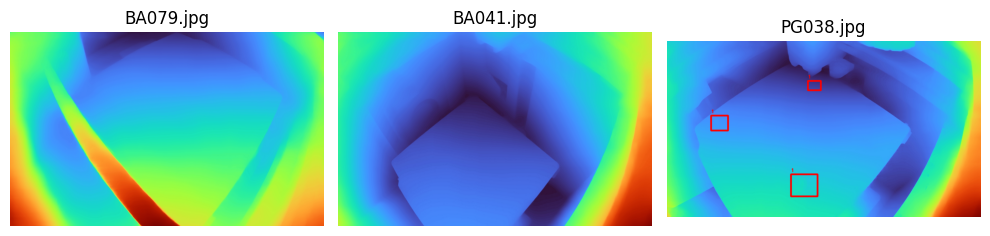

In [5]:
# Get a list of all image files in the folder
image_files = [f for f in os.listdir(train_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Check if there are enough images in the folder
if len(image_files) < 3:
    print(f"Err: Check folder paths")
    
else:
    # Select 3 random images
    selected_images = random.sample(image_files, 3)

    # Display the selected images with bounding boxes
    plt.figure(figsize=(10, 5))

    for i, img_file in enumerate(selected_images):
        # Read the image using OpenCV
        img_path = os.path.join(train_folder, img_file)
        img = cv2.imread(img_path)

        # Find the corresponding label file
        label_file = os.path.join(train_label_folder, os.path.splitext(img_file)[0] + '.txt')
        print(label_file)

        # If a label file exists, draw the bounding boxes
        if os.path.exists(label_file):
            img = draw_bounding_boxes(img, label_file)

        # Convert BGR to RGB for displaying with Matplotlib
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Plot the image
        plt.subplot(1, 3, i + 1)
        plt.imshow(img)
        plt.title(img_file)
        plt.axis('off')

    # Show the images
    plt.tight_layout()
    plt.show()

# Train Model
#### Use transfer learning on a pre-trained YOLOv11 medium sized model, then evaluate.

In [6]:
# Import stuff
from ultralytics import YOLO

In [9]:
# Create a new YOLO model from scratch
model = YOLO("yolo11m.yaml")

In [10]:
# Train the model using the previously found hyper
results = model.train(
    data = dataset_yaml_path,
    project = project_folder,
    name = "train",
    epochs = 50,              
    batch = 16) #32 better on Kaggle, but not enough memory on my GPU

New https://pypi.org/project/ultralytics/8.3.38 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.36  Python-3.11.9 torch-2.4.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolo11m.yaml, data=./datasets/depthpro_dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=3dprint_depthpro_small_yolov11m, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_ma

train: Scanning C:\Users\ChenYi\Documents\Github\AAI3001-Final-Project\datasets\depthpro_dataset\labels\train.cache... 
val: Scanning C:\Users\ChenYi\Documents\Github\AAI3001-Final-Project\datasets\depthpro_dataset\labels\val.cache... 15 i


Plotting labels to 3dprint_depthpro_small_yolov11m\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to 3dprint_depthpro_small_yolov11m\train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      8.42G      3.815      5.515      4.176         11        640: 100%|██████████| 8/8 [00:02<00:00,  2.79
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26    0.00019     0.0385   0.000487   4.87e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      8.54G      3.772      5.216      4.132         39        640: 100%|██████████| 8/8 [00:02<00:00,  3.44
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26   0.000121     0.0385    0.00014   4.96e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      8.56G      3.815      4.835      4.001         20        640: 100%|██████████| 8/8 [00:02<00:00,  3.89
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26   0.000116     0.0385    0.00168   0.000202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      8.58G      3.784      4.601      3.956         48        640: 100%|██████████| 8/8 [00:02<00:00,  3.80
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26   0.000117     0.0385   8.56e-05   4.26e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      8.58G      3.495      4.305      3.944         36        640: 100%|██████████| 8/8 [00:02<00:00,  3.87
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26   0.000117     0.0385    0.00126   0.000152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.58G      3.727      4.143      3.781         36        640: 100%|██████████| 8/8 [00:02<00:00,  3.87
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26   0.000117     0.0385   8.58e-05   3.45e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      8.63G      3.603      3.913      3.741         33        640: 100%|██████████| 8/8 [00:02<00:00,  3.90
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26   0.000234     0.0769   0.000195   6.28e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      8.57G      3.721      4.108      3.624         18        640: 100%|██████████| 8/8 [00:01<00:00,  4.00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26   0.000798      0.269   0.000972   0.000341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      8.62G      3.634      3.889      3.502         38        640: 100%|██████████| 8/8 [00:02<00:00,  3.95
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26    0.00107      0.462     0.0015   0.000528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      8.55G      3.831      3.772      3.421         47        640: 100%|██████████| 8/8 [00:01<00:00,  4.10
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0


                   all         21         26   0.000104     0.0385   5.79e-05   2.31e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       8.6G      3.828      3.758       3.35         33        640: 100%|██████████| 8/8 [00:02<00:00,  3.99
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26   0.000966      0.423    0.00277   0.000894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      8.58G      3.745      3.674       3.36         20        640: 100%|██████████| 8/8 [00:01<00:00,  4.01
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26   0.000929      0.385     0.0035   0.000856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      8.55G      3.669      3.595       3.28         28        640: 100%|██████████| 8/8 [00:01<00:00,  4.09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26    0.00106      0.462     0.0776     0.0131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      8.56G      3.891      3.725      3.146         25        640: 100%|██████████| 8/8 [00:01<00:00,  4.07
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26    0.00194      0.538     0.0284    0.00899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      8.56G       3.78      3.471      3.125         17        640: 100%|██████████| 8/8 [00:01<00:00,  4.10
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26     0.0021      0.577    0.00542    0.00224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      8.55G      3.775      3.521      3.112         17        640: 100%|██████████| 8/8 [00:01<00:00,  4.06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26    0.00218      0.577     0.0133    0.00314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      8.56G      3.692      3.483      3.017         28        640: 100%|██████████| 8/8 [00:01<00:00,  4.07
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26      0.514      0.231     0.0451    0.00659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      8.56G      3.706      3.359      2.952         19        640: 100%|██████████| 8/8 [00:01<00:00,  4.06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26      0.506      0.346     0.0268    0.00521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      8.53G      3.679      3.443      2.954         31        640: 100%|██████████| 8/8 [00:01<00:00,  4.09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26    0.00252      0.577     0.0199    0.00372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      8.55G      3.489       3.33       2.84         16        640: 100%|██████████| 8/8 [00:01<00:00,  4.10
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26      0.712     0.0595     0.0603    0.00803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      8.57G      3.763      3.551      2.857         12        640: 100%|██████████| 8/8 [00:01<00:00,  4.07
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26      0.699      0.154      0.104     0.0244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      8.59G       3.75      3.372      2.838         35        640: 100%|██████████| 8/8 [00:01<00:00,  4.05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26      0.717      0.148      0.127     0.0247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      8.54G      3.737      3.352      2.699         23        640: 100%|██████████| 8/8 [00:01<00:00,  4.11
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26      0.563     0.0769     0.0487     0.0131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      8.55G       3.73      3.284      2.776         24        640: 100%|██████████| 8/8 [00:01<00:00,  4.04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26      0.553     0.0385     0.0854     0.0251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      8.55G      3.633      3.202      2.713         28        640: 100%|██████████| 8/8 [00:01<00:00,  4.03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26      0.556     0.0769     0.0684     0.0117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      8.56G      3.809        3.3      2.745         38        640: 100%|██████████| 8/8 [00:01<00:00,  4.03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26      0.573      0.154     0.0441     0.0145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      8.56G      3.695      3.258       2.75         30        640: 100%|██████████| 8/8 [00:01<00:00,  4.02
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26      0.627      0.154     0.0821     0.0292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      8.63G      3.558      3.214      2.616         47        640: 100%|██████████| 8/8 [00:01<00:00,  4.07
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26      0.631      0.154     0.0667     0.0253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      8.55G      3.705      3.301       2.59         18        640: 100%|██████████| 8/8 [00:01<00:00,  4.11
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26       0.72     0.0385     0.0379      0.014



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      8.55G       3.65      3.141      2.556         33        640: 100%|██████████| 8/8 [00:01<00:00,  4.09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26      0.522     0.0769     0.0221    0.00503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      8.55G       3.59       3.23      2.536         50        640: 100%|██████████| 8/8 [00:01<00:00,  4.08
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26      0.631     0.0769      0.049     0.0101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      8.57G      3.555      3.118      2.452         17        640: 100%|██████████| 8/8 [00:01<00:00,  4.13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26      0.773      0.192      0.176     0.0529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      8.58G      3.506      3.064      2.458         28        640: 100%|██████████| 8/8 [00:01<00:00,  4.09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26      0.722      0.192      0.157     0.0592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      8.55G      3.494      3.167      2.498         20        640: 100%|██████████| 8/8 [00:01<00:00,  4.05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26      0.638      0.192      0.097     0.0322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      8.55G      3.593      3.203      2.525         41        640: 100%|██████████| 8/8 [00:01<00:00,  4.09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26      0.636      0.115     0.0681     0.0217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      8.55G      3.469      3.137      2.488         29        640: 100%|██████████| 8/8 [00:01<00:00,  4.07
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26      0.794     0.0769     0.0845     0.0235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      8.54G      3.629      3.169      2.506         13        640: 100%|██████████| 8/8 [00:02<00:00,  3.99
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26      0.616     0.0769     0.0606     0.0202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      8.57G      3.508      3.032      2.482         25        640: 100%|██████████| 8/8 [00:01<00:00,  4.04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26      0.676      0.154     0.0946     0.0255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      8.52G      3.576       3.12      2.565         20        640: 100%|██████████| 8/8 [00:01<00:00,  4.10
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26       0.63      0.115     0.0828     0.0275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      8.55G      3.609      3.145      2.494         18        640: 100%|██████████| 8/8 [00:01<00:00,  4.03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26      0.648      0.115     0.0892     0.0325


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      8.54G      3.283      3.238      2.572         11        640: 100%|██████████| 8/8 [00:04<00:00,  1.98
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26      0.753      0.154      0.149     0.0417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      8.54G      3.299      3.203      2.511         16        640: 100%|██████████| 8/8 [00:01<00:00,  4.01
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26      0.711      0.154      0.127     0.0439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      8.54G      3.313      3.151      2.457         15        640: 100%|██████████| 8/8 [00:01<00:00,  4.10
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26       0.67      0.154      0.137     0.0449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      8.54G        3.2      3.131        2.4          4        640: 100%|██████████| 8/8 [00:01<00:00,  4.10
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26       0.62      0.154      0.133     0.0441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      8.54G      3.275      3.091      2.418         32        640: 100%|██████████| 8/8 [00:01<00:00,  4.06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26      0.596      0.154      0.116     0.0438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      8.54G      3.302      3.116      2.462          9        640: 100%|██████████| 8/8 [00:01<00:00,  4.08
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26      0.716     0.0769      0.126     0.0441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      8.54G      3.305      3.152      2.408         17        640: 100%|██████████| 8/8 [00:01<00:00,  4.05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26      0.875     0.0769      0.122     0.0431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      8.54G      3.212      3.119      2.331         16        640: 100%|██████████| 8/8 [00:01<00:00,  4.09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26       0.84     0.0769      0.124     0.0447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      8.54G      3.206      3.037      2.466         17        640: 100%|██████████| 8/8 [00:01<00:00,  4.08
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26      0.602      0.192       0.14     0.0467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      8.54G      3.261      3.036      2.451         25        640: 100%|██████████| 8/8 [00:01<00:00,  4.08
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         21         26      0.609      0.192      0.142     0.0475



50 epochs completed in 0.044 hours.
Optimizer stripped from 3dprint_depthpro_small_yolov11m\train\weights\last.pt, 40.5MB
Optimizer stripped from 3dprint_depthpro_small_yolov11m\train\weights\best.pt, 40.5MB

Validating 3dprint_depthpro_small_yolov11m\train\weights\best.pt...
WARNING  validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.36  Python-3.11.9 torch-2.4.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLO11m summary (fused): 303 layers, 20,032,345 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0


                   all         21         26      0.722      0.192      0.157     0.0592
                 purge          3         13          1          0    0.00334    0.00101
                 print         12         13      0.443      0.385      0.311      0.117
Speed: 0.0ms preprocess, 6.3ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to 3dprint_depthpro_small_yolov11m\train


In [ ]:
# Evaluate the model's performance on the test set
results = model.val(data=dataset_yaml_path, project=project_folder, name='test', split='test')

# View Results

In [ ]:
# Load the generated images
batch_number = 0
if (batch_number):
    image1 = project_folder + f"/test{batch_number}/val_batch0_labels.jpg"
    image2 = project_folder + f"/test{batch_number}/val_batch0_pred.jpg"
    image3 = project_folder + f"/test{batch_number}/val_batch1_labels.jpg"
    image4 = project_folder + f"/test{batch_number}/val_batch1_pred.jpg"
else:
    image1 = project_folder + f"/test/val_batch0_labels.jpg"
    image2 = project_folder + f"/test/val_batch0_pred.jpg"
    image3 = project_folder + f"/test/val_batch0_labels.jpg"
    image4 = project_folder + f"/test/val_batch0_pred.jpg"

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print(f"Previewing results from project: '{project_folder}'\n")

# Load the image
count = 1
for path in [image1, image2, image3, image4]:
        
    if ((count % 2) == 0):
        print(f"[PREDICTION] image: {path} ------------------------------------\n")
    else:
        print(f"[LABEL] image: {path} ------------------------------------\n")
    count += 1;
    
    img = mpimg.imread(path)
    plt.figure(figsize=(16, 16))

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()
    print("\n")

# Evaluation
#### *On initial dataset of 350 images!*
- Overall it performed unexpectedly well based on the generated images. Except for FC46.jpg where it was unable to detect the very small loose filament oozing from the nozzle.
- It was able to correctly identify at least one failure from each of the images with failures. 
- Crucially, none of the background images have any false positives. This is important, as it means it has a low false positive rate, or high precision. In most AI fault detection systems, a false positive will cause the print to stop until a human gives it the clearance to proceed if it was a false positive, wasting time.**